Dataset Shape: (1400, 3)
                                         Comment     Label Language
0                                   ইদুরের গর্তে  Negative   BANGLA
1                                     এরা এখন কই  Negative   BANGLA
2                                        আদু ভাই  Negative   BANGLA
3              সাদ্দাম তুই কই,,,?\nতোকে খুঁজতাছি  Negative   BANGLA
4  এখন দেখি বাংলাদেশে ছাত্রলীগের কোনো জায়গা নেই  Negative   BANGLA


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map:   0%|          | 0/1120 [00:00<?, ? examples/s]Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Map: 100%|██████████| 280/280 [00:00<00:00, 41798.24 examples/s]
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\U

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.644300,0.623542,0.692857,0.567149
2,0.650400,0.616914,0.692857,0.567149
3,0.623600,0.617035,0.692857,0.567149
4,0.580300,0.618750,0.692857,0.567149
5,0.630000,0.627206,0.692857,0.567149
6,0.628700,0.616886,0.692857,0.567149
7,0.627400,0.618421,0.692857,0.567149
8,0.603500,0.619619,0.692857,0.567149
9,0.599500,0.617588,0.692857,0.567149
10,0.607600,0.617895,0.692857,0.567149


Evaluation results: {'eval_loss': 0.6168860197067261, 'eval_accuracy': 0.6928571428571428, 'eval_f1': 0.5671488848704039, 'eval_runtime': 0.4588, 'eval_samples_per_second': 610.315, 'eval_steps_per_second': 39.235, 'epoch': 10.0}
Classification Report:
               precision    recall  f1-score   support

    Negative       0.69      1.00      0.82       194
    Positive       0.00      0.00      0.00        86

    accuracy                           0.69       280
   macro avg       0.35      0.50      0.41       280
weighted avg       0.48      0.69      0.57       280



c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


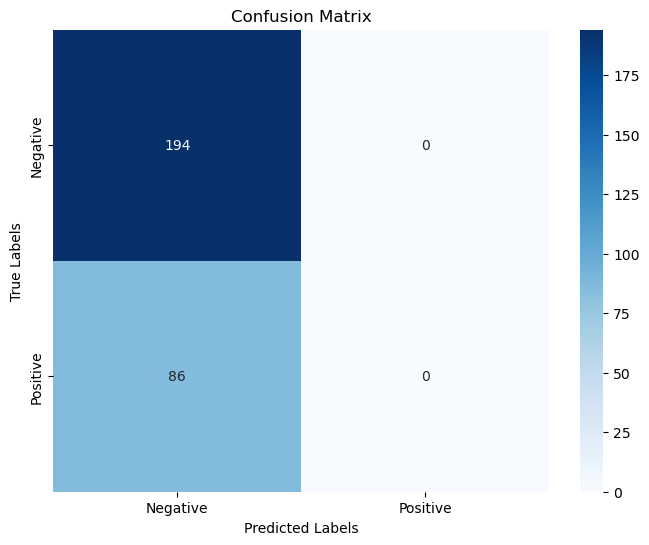

In [12]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

# Load dataset
df = pd.read_csv("data/bangla_political_comments.csv")
print("Dataset Shape:", df.shape)
print(df.head())

# Check for missing values
df.dropna(inplace=True)

# Shuffle data
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Extract features and labels
X = df['Comment']
y = df['Label']

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Convert to Hugging Face dataset
data = Dataset.from_pandas(pd.DataFrame({'text': X, 'label': y_encoded}))
data = data.train_test_split(test_size=0.2, seed=42)

# Load model and tokenizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = 'xlnet-base-cased'
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(le.classes_)).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenization
def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True)

data = data.map(tokenize_function, batched=True)
data = data.remove_columns(['text']).rename_column('label', 'labels')
data.set_format('torch')

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_strategy='epoch',
    load_best_model_at_end=True,
    report_to=[]
)

# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=data['train'],
    eval_dataset=data['test'],
    tokenizer=tokenizer,
    compute_metrics=lambda eval_pred: {
        "accuracy": accuracy_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1)),
        "f1": f1_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1), average="weighted")
    }
)

# Train model
trainer.train()

# Evaluate model
eval_results = trainer.evaluate()
print("Evaluation results:", eval_results)

# Generate predictions
predictions_output = trainer.predict(data['test'])
predictions = np.argmax(predictions_output.predictions, axis=1)
labels = predictions_output.label_ids

# Classification report
report = classification_report(labels, predictions, target_names=le.classes_)
print("Classification Report:\n", report)

# Confusion matrix
conf_matrix = confusion_matrix(labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


Dataset Shape: (1400, 3)
                                         Comment     Label Language
0                                   ইদুরের গর্তে  Negative   BANGLA
1                                     এরা এখন কই  Negative   BANGLA
2                                        আদু ভাই  Negative   BANGLA
3              সাদ্দাম তুই কই,,,?\nতোকে খুঁজতাছি  Negative   BANGLA
4  এখন দেখি বাংলাদেশে ছাত্রলীগের কোনো জায়গা নেই  Negative   BANGLA


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map:   0%|          | 0/1120 [00:00<?, ? examples/s]Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Map: 100%|██████████| 280/280 [00:00<00:00, 37843.75 examples/s]
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\U

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.286700,0.615028,0.692857,0.567149
2,1.228700,0.623615,0.692857,0.567149
3,1.264400,0.616139,0.692857,0.567149
4,1.226100,0.618497,0.692857,0.567149
5,1.180400,0.620473,0.692857,0.567149
6,1.248000,0.614548,0.692857,0.567149
7,1.244900,0.616335,0.692857,0.567149
8,1.238100,0.615411,0.692857,0.567149
9,1.227500,0.615456,0.692857,0.567149
10,1.181500,0.616053,0.692857,0.567149


Evaluation results: {'eval_loss': 0.6150281429290771, 'eval_accuracy': 0.6928571428571428, 'eval_f1': 0.5671488848704039, 'eval_runtime': 0.4782, 'eval_samples_per_second': 585.588, 'eval_steps_per_second': 18.822, 'epoch': 11.342857142857143}
Classification Report:
               precision    recall  f1-score   support

    Negative       0.69      1.00      0.82       194
    Positive       0.00      0.00      0.00        86

    accuracy                           0.69       280
   macro avg       0.35      0.50      0.41       280
weighted avg       0.48      0.69      0.57       280



c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


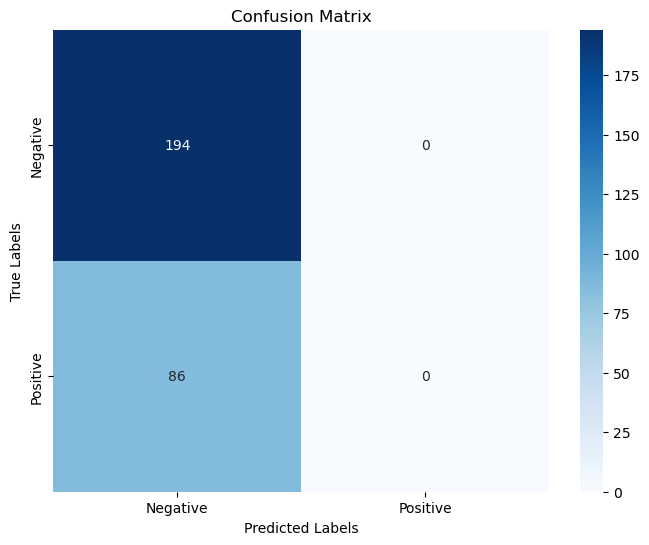

In [3]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

torch.cuda.empty_cache()

# Load dataset
df = pd.read_csv("data/bangla_political_comments.csv")
print("Dataset Shape:", df.shape)
print(df.head())

# Check for missing values
df.dropna(inplace=True)

# Shuffle data
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Extract features and labels
X = df['Comment']
y = df['Label']

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Convert to Hugging Face dataset
data = Dataset.from_pandas(pd.DataFrame({'text': X, 'label': y_encoded}))
data = data.train_test_split(test_size=0.2, seed=42)

# Load model and tokenizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = 'xlnet-base-cased'
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(le.classes_)).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenization
def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True)

data = data.map(tokenize_function, batched=True)
data = data.remove_columns(['text']).rename_column('label', 'labels')
data.set_format('torch')

# Training arguments
# Optimized Training Arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,  # Reduced for stable training
    per_device_train_batch_size=32,  # Increased batch size
    per_device_eval_batch_size=32,
    num_train_epochs=12,  # Increased to allow better learning
    weight_decay=0.02,  # Higher weight decay to reduce overfitting
    logging_dir='./logs',
    logging_steps=10,
    save_strategy='epoch',
    load_best_model_at_end=True,
    lr_scheduler_type="cosine",  # Helps stabilize training
    gradient_accumulation_steps=2,  # Handles larger batch size if memory issues arise
    warmup_ratio=0.1,  # Gradually increases LR in early epochs
    metric_for_best_model="accuracy",  # Ensures best accuracy
    save_total_limit=2,  # Keeps only the best models
    report_to=[]
)


# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=data['train'],
    eval_dataset=data['test'],
    tokenizer=tokenizer,
    compute_metrics=lambda eval_pred: {
        "accuracy": accuracy_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1)),
        "f1": f1_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1), average="weighted")
    }
)

# Train model
trainer.train()

# Evaluate model
eval_results = trainer.evaluate()
print("Evaluation results:", eval_results)

# Generate predictions
predictions_output = trainer.predict(data['test'])
predictions = np.argmax(predictions_output.predictions, axis=1)
labels = predictions_output.label_ids

# Classification report
report = classification_report(labels, predictions, target_names=le.classes_)
print("Classification Report:\n", report)

# Confusion matrix
conf_matrix = confusion_matrix(labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


Dataset Shape: (1400, 3)
                                         Comment     Label Language
0                                   ইদুরের গর্তে  Negative   BANGLA
1                                     এরা এখন কই  Negative   BANGLA
2                                        আদু ভাই  Negative   BANGLA
3              সাদ্দাম তুই কই,,,?\nতোকে খুঁজতাছি  Negative   BANGLA
4  এখন দেখি বাংলাদেশে ছাত্রলীগের কোনো জায়গা নেই  Negative   BANGLA


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map:   0%|          | 0/2240 [00:00<?, ? examples/s]Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Map: 100%|██████████| 560/560 [00:00<00:00, 40094.40 examples/s]
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\U

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.769600,0.707338,0.435714,0.456081
2,0.662100,0.616371,0.705357,0.584966
3,0.634200,0.637697,0.705357,0.584966
4,0.673000,0.630564,0.705357,0.584966
5,0.652900,0.640232,0.705357,0.584966
6,0.644500,0.640542,0.707143,0.585834
7,0.661000,0.637324,0.707143,0.585834
8,0.602700,0.639693,0.707143,0.585834
9,0.620100,0.636673,0.707143,0.585834
10,0.610700,0.636277,0.707143,0.585834


Evaluation results: {'eval_loss': 0.636277437210083, 'eval_accuracy': 0.7071428571428572, 'eval_f1': 0.585833831440526, 'eval_runtime': 0.9088, 'eval_samples_per_second': 616.228, 'eval_steps_per_second': 38.514, 'epoch': 10.0}
Classification Report:
               precision    recall  f1-score   support

    Negative       0.71      1.00      0.83       396
    Positive       0.00      0.00      0.00       164

    accuracy                           0.71       560
   macro avg       0.35      0.50      0.41       560
weighted avg       0.50      0.71      0.59       560



c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


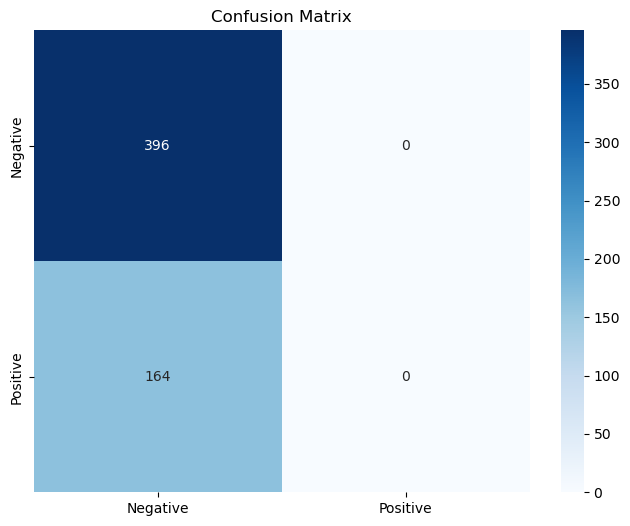

In [8]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import TrainerCallback
from peft import get_peft_model, LoraConfig, TaskType
from torch.utils.data import DataLoader
from nlpaug.augmenter.word import SynonymAug
from transformers.optimization import AdamW

# Empty CUDA cache
torch.cuda.empty_cache()

def augment_text(text):
    words = text.split()
    if len(words) < 5:
        return text
    num_to_replace = max(1, len(words) // 5)
    indices = np.random.choice(len(words), num_to_replace, replace=False)
    aug = SynonymAug()
    augmented_words = aug.augment(text)
    return ' '.join(augmented_words)

# Load dataset
df = pd.read_csv('data/bangla_political_comments.csv')
print("Dataset Shape:", df.shape)
print(df.head())

df.dropna(inplace=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Apply text augmentation
augmented_texts = [augment_text(text) for text in df['Comment']]
df['AugmentedText'] = augmented_texts
df = pd.concat([df, pd.DataFrame({'Comment': augmented_texts, 'Label': df['Label']})], ignore_index=True)

# Encode labels
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])

# Convert to Hugging Face Dataset
hf_dataset = Dataset.from_pandas(df)
split_datasets = hf_dataset.train_test_split(test_size=0.2, seed=42)

# Load model and tokenizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = 'xlnet-base-cased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Apply LoRA for parameter-efficient fine-tuning
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=["layer_1", "layer_2"],  # Apply LoRA to Linear layers in the feedforward part
    bias="none"
)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=len(le.classes_)).to(device)
model = get_peft_model(model, peft_config)

# Tokenization
def tokenize_function(example):
    return tokenizer(example['Comment'], padding='max_length', truncation=True)

tokenized_datasets = split_datasets.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["Comment", "Language", "AugmentedText"])
tokenized_datasets = tokenized_datasets.rename_column("Label", "labels").with_format("torch")

# Optimized Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=1e-5,  # Lower learning rate for LoRA tuning
    per_device_train_batch_size=16,  # Keeping batch size at 16
    per_device_eval_batch_size=16,
    num_train_epochs=10,  # Reduced epochs to prevent overfitting
    weight_decay=0.03,  # Increased regularization
    logging_dir='./logs',
    logging_steps=50,
    save_strategy='epoch',
    save_total_limit=2,
    metric_for_best_model='accuracy',
    warmup_ratio=0.1,
    report_to=[]
)

# PEFT-enabled Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=lambda eval_pred: {
        "accuracy": accuracy_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1)),
        "f1": f1_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1), average="weighted")
    }
)

# Train model
trainer.train()

# Evaluate model
eval_results = trainer.evaluate()
print("Evaluation results:", eval_results)

# Generate classification report
predictions_output = trainer.predict(tokenized_datasets['test'])
preds = np.argmax(predictions_output.predictions, axis=1)
report = classification_report(predictions_output.label_ids, preds, target_names=le.classes_)
print("Classification Report:\n", report)

# Confusion Matrix
conf_matrix = confusion_matrix(predictions_output.label_ids, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.show()


Dataset Shape: (1400, 3)
                                         Comment     Label Language
0                                   ইদুরের গর্তে  Negative   BANGLA
1                                     এরা এখন কই  Negative   BANGLA
2                                        আদু ভাই  Negative   BANGLA
3              সাদ্দাম তুই কই,,,?\nতোকে খুঁজতাছি  Negative   BANGLA
4  এখন দেখি বাংলাদেশে ছাত্রলীগের কোনো জায়গা নেই  Negative   BANGLA


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map:   0%|          | 0/2240 [00:00<?, ? examples/s]Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Map: 100%|██████████| 560/560 [00:00<00:00, 38418.17 examples/s]
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\U

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.687300,0.644461,0.710714,0.622279
2,0.649500,0.606635,0.707143,0.585834
3,0.627900,0.611875,0.707143,0.585834
4,0.677000,0.611040,0.707143,0.585834
5,0.642400,0.611493,0.707143,0.585834
6,0.642900,0.612265,0.707143,0.585834
7,0.645800,0.610623,0.707143,0.585834
8,0.606000,0.610792,0.707143,0.585834
9,0.616700,0.610597,0.707143,0.585834
10,0.608900,0.610523,0.707143,0.585834


Evaluation results: {'eval_loss': 0.6105231046676636, 'eval_accuracy': 0.7071428571428572, 'eval_f1': 0.585833831440526, 'eval_runtime': 0.9064, 'eval_samples_per_second': 617.845, 'eval_steps_per_second': 38.615, 'epoch': 10.0}
Classification Report:
               precision    recall  f1-score   support

    Negative       0.71      1.00      0.83       396
    Positive       0.00      0.00      0.00       164

    accuracy                           0.71       560
   macro avg       0.35      0.50      0.41       560
weighted avg       0.50      0.71      0.59       560



c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


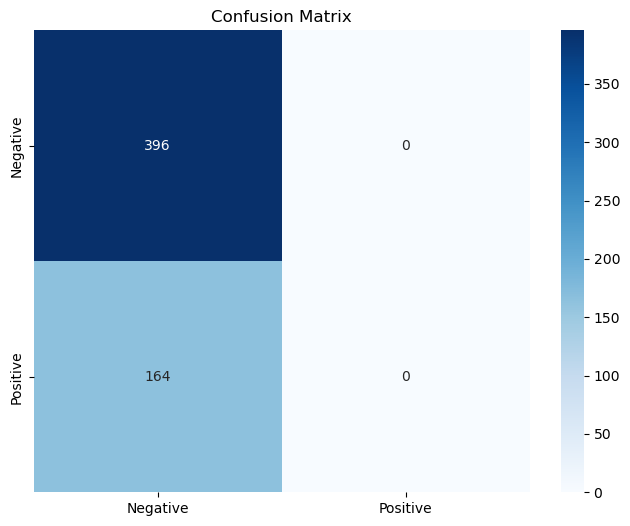

In [9]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from peft import get_peft_model, LoraConfig, TaskType
from torch.utils.data import DataLoader
from nlpaug.augmenter.word import SynonymAug
from transformers.optimization import AdamW

# Empty CUDA cache
torch.cuda.empty_cache()

def augment_text(text):
    words = text.split()
    if len(words) < 5:
        return text
    num_to_replace = max(1, len(words) // 5)
    indices = np.random.choice(len(words), num_to_replace, replace=False)
    aug = SynonymAug()
    augmented_words = aug.augment(text)
    return ' '.join(augmented_words)

# Load dataset
df = pd.read_csv('data/bangla_political_comments.csv')
print("Dataset Shape:", df.shape)
print(df.head())

df.dropna(inplace=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Apply text augmentation
augmented_texts = [augment_text(text) for text in df['Comment']]
df['AugmentedText'] = augmented_texts
df = pd.concat([df, pd.DataFrame({'Comment': augmented_texts, 'Label': df['Label']})], ignore_index=True)

# Encode labels
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])

# Convert to Hugging Face Dataset
hf_dataset = Dataset.from_pandas(df)
split_datasets = hf_dataset.train_test_split(test_size=0.2, seed=42)

# Load model and tokenizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = 'xlnet-base-cased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Apply LoRA for parameter-efficient fine-tuning
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=["layer_1", "layer_2"],  # Apply LoRA to Linear layers in the feedforward part
    bias="none"
)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=len(le.classes_)).to(device)
model = get_peft_model(model, peft_config)

# Tokenization
def tokenize_function(example):
    return tokenizer(example['Comment'], padding='max_length', truncation=True)

tokenized_datasets = split_datasets.map(tokenize_function, batched=True)

# Ensure columns to remove exist
columns_to_remove = ["Comment", "Language", "AugmentedText"]
existing_columns = [col for col in columns_to_remove if col in tokenized_datasets["train"].column_names]
tokenized_datasets = tokenized_datasets.remove_columns(existing_columns)

# Rename label column
tokenized_datasets = tokenized_datasets.rename_column("Label", "labels").with_format("torch")

# Optimized Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=1e-5,  # Lower learning rate for LoRA tuning
    per_device_train_batch_size=16,  # Keeping batch size at 16
    per_device_eval_batch_size=16,
    num_train_epochs=10,  # Reduced epochs to prevent overfitting
    weight_decay=0.03,  # Increased regularization
    logging_dir='./logs',
    logging_steps=50,
    save_strategy='epoch',
    save_total_limit=2,
    metric_for_best_model='accuracy',
    warmup_ratio=0.1,
    report_to=[]
)

# PEFT-enabled Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=lambda eval_pred: {
        "accuracy": accuracy_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1)),
        "f1": f1_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1), average="weighted")
    }
)

# Train model
trainer.train()

# Evaluate model
eval_results = trainer.evaluate()
print("Evaluation results:", eval_results)

# Generate classification report
predictions_output = trainer.predict(tokenized_datasets['test'])
preds = np.argmax(predictions_output.predictions, axis=1)
report = classification_report(predictions_output.label_ids, preds, target_names=le.classes_)
print("Classification Report:\n", report)

# Confusion Matrix
conf_matrix = confusion_matrix(predictions_output.label_ids, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.show()


Dataset Shape: (1400, 3)
                                         Comment     Label Language
0                                   ইদুরের গর্তে  Negative   BANGLA
1                                     এরা এখন কই  Negative   BANGLA
2                                        আদু ভাই  Negative   BANGLA
3              সাদ্দাম তুই কই,,,?\nতোকে খুঁজতাছি  Negative   BANGLA
4  এখন দেখি বাংলাদেশে ছাত্রলীগের কোনো জায়গা নেই  Negative   BANGLA


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map:   0%|          | 0/2240 [00:00<?, ? examples/s]Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Map: 100%|██████████| 560/560 [00:00<00:00, 36675.52 examples/s]
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\U

Epoch,Training Loss,Validation Loss,Accuracy,F1,Positive Precision,Positive Recall,Positive F1
1,0.771300,0.617609,0.705357,0.584966,0.000000,0.000000,0.000000
2,0.640300,0.636638,0.705357,0.584966,0.000000,0.000000,0.000000
3,0.636100,0.628478,0.707143,0.585834,0.000000,0.000000,0.000000
4,0.674500,0.614479,0.707143,0.585834,0.000000,0.000000,0.000000
5,0.656000,0.619793,0.707143,0.585834,0.000000,0.000000,0.000000


c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\U

Evaluation results: {'eval_loss': 0.6284780502319336, 'eval_accuracy': 0.7071428571428572, 'eval_f1': 0.585833831440526, 'eval_positive_precision': 0.0, 'eval_positive_recall': 0.0, 'eval_positive_f1': 0.0, 'eval_runtime': 0.9276, 'eval_samples_per_second': 603.722, 'eval_steps_per_second': 37.733, 'epoch': 5.0}


c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\U

Classification Report:
               precision    recall  f1-score   support

    Negative       0.71      1.00      0.83       396
    Positive       0.00      0.00      0.00       164

    accuracy                           0.71       560
   macro avg       0.35      0.50      0.41       560
weighted avg       0.50      0.71      0.59       560



c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


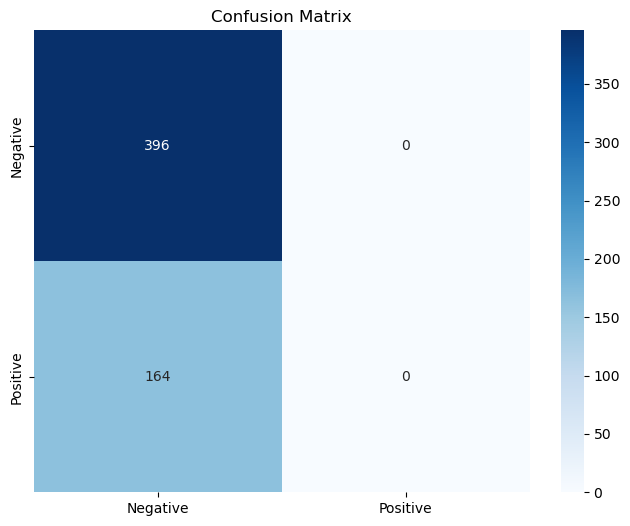

In [11]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from peft import get_peft_model, LoraConfig, TaskType
from torch.utils.data import DataLoader
from nlpaug.augmenter.word import SynonymAug
from transformers import EarlyStoppingCallback
from torch.nn import CrossEntropyLoss

# Empty CUDA cache
torch.cuda.empty_cache()

def augment_text(text):
    words = text.split()
    if len(words) < 5:
        return text
    num_to_replace = max(1, len(words) // 5)
    indices = np.random.choice(len(words), num_to_replace, replace=False)
    aug = SynonymAug()
    augmented_words = aug.augment(text)
    return ' '.join(augmented_words)

# Load dataset
df = pd.read_csv('data/bangla_political_comments.csv')
print("Dataset Shape:", df.shape)
print(df.head())

df.dropna(inplace=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Apply text augmentation
augmented_texts = [augment_text(text) for text in df['Comment']]
df['AugmentedText'] = augmented_texts
df = pd.concat([df, pd.DataFrame({'Comment': augmented_texts, 'Label': df['Label']})], ignore_index=True)

# Encode labels
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])

# Convert to Hugging Face Dataset
hf_dataset = Dataset.from_pandas(df)
split_datasets = hf_dataset.train_test_split(test_size=0.2, seed=42)

# Load model and tokenizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = 'xlnet-base-cased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Apply LoRA for parameter-efficient fine-tuning
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=["layer_1", "layer_2"],  # Apply LoRA to Linear layers in the feedforward part
    bias="none"
)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=len(le.classes_)).to(device)
model = get_peft_model(model, peft_config)

# Define class weights based on the class distribution
class_weights = torch.tensor([0.3, 0.7]).to(device)  # Adjust based on class distribution

# Override the model's loss function with class weights
def compute_loss(logits, labels):
    loss_fct = CrossEntropyLoss(weight=class_weights)
    return loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))

# Tokenization
def tokenize_function(example):
    return tokenizer(example['Comment'], padding='max_length', truncation=True)

tokenized_datasets = split_datasets.map(tokenize_function, batched=True)

# Ensure columns to remove exist
columns_to_remove = ["Comment", "Language", "AugmentedText"]
existing_columns = [col for col in columns_to_remove if col in tokenized_datasets["train"].column_names]
tokenized_datasets = tokenized_datasets.remove_columns(existing_columns)

# Rename label column
tokenized_datasets = tokenized_datasets.rename_column("Label", "labels").with_format("torch")

# Optimized Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=3e-5,  # Increased learning rate
    per_device_train_batch_size=16,  # Keeping batch size at 16
    per_device_eval_batch_size=16,
    num_train_epochs=10,  # Reduced epochs to prevent overfitting
    weight_decay=0.03,  # Increased regularization
    logging_dir='./logs',
    logging_steps=50,
    save_strategy='epoch',
    save_total_limit=2,
    metric_for_best_model='accuracy',
    warmup_ratio=0.1,
    report_to=[],
    # Add EarlyStopping callback
    load_best_model_at_end=True,
    greater_is_better=True
)

# PEFT-enabled Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=lambda eval_pred: {
        "accuracy": accuracy_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1)),
        "f1": f1_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1), average="weighted"),
        "positive_precision": classification_report(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1), output_dict=True)['1']['precision'],
        "positive_recall": classification_report(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1), output_dict=True)['1']['recall'],
        "positive_f1": classification_report(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1), output_dict=True)['1']['f1-score'],
    },
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],  # Early stopping after 2 epochs with no improvement
)

# Train model
trainer.train()

# Evaluate model
eval_results = trainer.evaluate()
print("Evaluation results:", eval_results)

# Generate classification report
predictions_output = trainer.predict(tokenized_datasets['test'])
preds = np.argmax(predictions_output.predictions, axis=1)
report = classification_report(predictions_output.label_ids, preds, target_names=le.classes_)
print("Classification Report:\n", report)

# Confusion Matrix
conf_matrix = confusion_matrix(predictions_output.label_ids, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.show()


Dataset Shape: (1400, 3)
                                         Comment     Label Language
0                                   ইদুরের গর্তে  Negative   BANGLA
1                                     এরা এখন কই  Negative   BANGLA
2                                        আদু ভাই  Negative   BANGLA
3              সাদ্দাম তুই কই,,,?\nতোকে খুঁজতাছি  Negative   BANGLA
4  এখন দেখি বাংলাদেশে ছাত্রলীগের কোনো জায়গা নেই  Negative   BANGLA


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map:   0%|          | 0/2240 [00:00<?, ? examples/s]Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Map: 100%|██████████| 560/560 [00:00<00:00, 41631.55 examples/s]
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\U

Epoch,Training Loss,Validation Loss,Accuracy,F1,Positive Precision,Positive Recall,Positive F1
1,0.674900,0.605005,0.707143,0.585834,0.000000,0.000000,0.000000
2,0.644100,0.609858,0.707143,0.585834,0.000000,0.000000,0.000000
3,0.626600,0.613070,0.707143,0.585834,0.000000,0.000000,0.000000


c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\U

Evaluation results: {'eval_loss': 0.6050052046775818, 'eval_accuracy': 0.7071428571428572, 'eval_f1': 0.585833831440526, 'eval_positive_precision': 0.0, 'eval_positive_recall': 0.0, 'eval_positive_f1': 0.0, 'eval_runtime': 0.9057, 'eval_samples_per_second': 618.322, 'eval_steps_per_second': 38.645, 'epoch': 3.0}


c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\U

Classification Report:
               precision    recall  f1-score   support

    Negative       0.71      1.00      0.83       396
    Positive       0.00      0.00      0.00       164

    accuracy                           0.71       560
   macro avg       0.35      0.50      0.41       560
weighted avg       0.50      0.71      0.59       560



c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


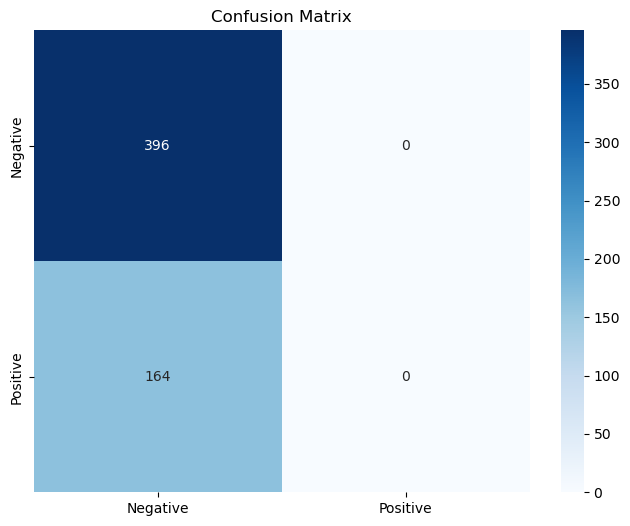

In [13]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from peft import get_peft_model, LoraConfig, TaskType
from torch.utils.data import DataLoader
from nlpaug.augmenter.word import SynonymAug
from transformers import EarlyStoppingCallback
from torch.nn import CrossEntropyLoss

# Empty CUDA cache
torch.cuda.empty_cache()

def augment_text(text):
    words = text.split()
    if len(words) < 5:
        return text
    num_to_replace = max(1, len(words) // 5)
    indices = np.random.choice(len(words), num_to_replace, replace=False)
    aug = SynonymAug()
    augmented_words = aug.augment(text)
    return ' '.join(augmented_words)

# Load dataset
df = pd.read_csv('data/bangla_political_comments.csv')
print("Dataset Shape:", df.shape)
print(df.head())

df.dropna(inplace=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Apply text augmentation
augmented_texts = [augment_text(text) for text in df['Comment']]
df['AugmentedText'] = augmented_texts
df = pd.concat([df, pd.DataFrame({'Comment': augmented_texts, 'Label': df['Label']})], ignore_index=True)

# Encode labels
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])

# Convert to Hugging Face Dataset
hf_dataset = Dataset.from_pandas(df)
split_datasets = hf_dataset.train_test_split(test_size=0.2, seed=42)

# Load model and tokenizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = 'xlnet-base-cased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Apply LoRA for parameter-efficient fine-tuning
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=["layer_1", "layer_2"],  # Apply LoRA to Linear layers in the feedforward part
    bias="none"
)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=len(le.classes_)).to(device)
model = get_peft_model(model, peft_config)

# Define class weights based on the class distribution
class_weights = torch.tensor([0.3, 0.7]).to(device)  # Adjust based on class distribution

# Override the model's loss function with class weights
def compute_loss(logits, labels):
    loss_fct = CrossEntropyLoss(weight=class_weights)
    return loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))

# Tokenization
def tokenize_function(example):
    return tokenizer(example['Comment'], padding='max_length', truncation=True)

tokenized_datasets = split_datasets.map(tokenize_function, batched=True)

# Ensure columns to remove exist
columns_to_remove = ["Comment", "Language", "AugmentedText"]
existing_columns = [col for col in columns_to_remove if col in tokenized_datasets["train"].column_names]
tokenized_datasets = tokenized_datasets.remove_columns(existing_columns)

# Rename label column
tokenized_datasets = tokenized_datasets.rename_column("Label", "labels").with_format("torch")

# Optimized Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=3e-5,  # Increased learning rate
    per_device_train_batch_size=16,  # Keeping batch size at 16
    per_device_eval_batch_size=16,
    num_train_epochs=10,  # Reduced epochs to prevent overfitting
    weight_decay=0.03,  # Increased regularization
    logging_dir='./logs',
    logging_steps=50,
    save_strategy='epoch',
    save_total_limit=2,
    metric_for_best_model='accuracy',
    warmup_ratio=0.1,
    report_to=[],
    # Add EarlyStopping callback
    load_best_model_at_end=True,
    greater_is_better=True
)

# PEFT-enabled Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=lambda eval_pred: {
        "accuracy": accuracy_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1)),
        "f1": f1_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1), average="weighted"),
        "positive_precision": classification_report(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1), output_dict=True)['1']['precision'],
        "positive_recall": classification_report(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1), output_dict=True)['1']['recall'],
        "positive_f1": classification_report(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1), output_dict=True)['1']['f1-score'],
    },
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],  # Early stopping after 2 epochs with no improvement
)

# Train model
trainer.train()

# Evaluate model
eval_results = trainer.evaluate()
print("Evaluation results:", eval_results)

# Generate classification report
predictions_output = trainer.predict(tokenized_datasets['test'])
preds = np.argmax(predictions_output.predictions, axis=1)
report = classification_report(predictions_output.label_ids, preds, target_names=le.classes_)
print("Classification Report:\n", report)

# Confusion Matrix
conf_matrix = confusion_matrix(predictions_output.label_ids, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.show()
